In [3]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)


In [5]:
os.makedirs("outputs", exist_ok=True)
os.makedirs("model", exist_ok=True)


In [7]:
data = load_breast_cancer()
X = data.data
y = data.target

print("Dataset shape:", X.shape)
print("Class distribution:", np.bincount(y))


Dataset shape: (569, 30)
Class distribution: [212 357]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 455
Testing samples: 114


In [11]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True))
])

pipeline


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(probability=True))])

In [13]:
param_grid = {
    "svm__kernel": ["linear", "rbf"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.001]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 0.01, 0.001],
                         'svm__kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [15]:
best_model = grid.best_estimator_

print("Best Parameters:")
print(grid.best_params_)

with open("outputs/best_params.txt", "w") as f:
    f.write(str(grid.best_params_))


Best Parameters:
{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


In [17]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]


In [19]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

with open("outputs/confusion_matrix.txt", "w") as f:
    f.write(str(cm))

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

with open("outputs/classification_report.txt", "w") as f:
    f.write(report)


Confusion Matrix:
 [[41  1]
 [ 1 71]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



AUC Score: 0.9976851851851851


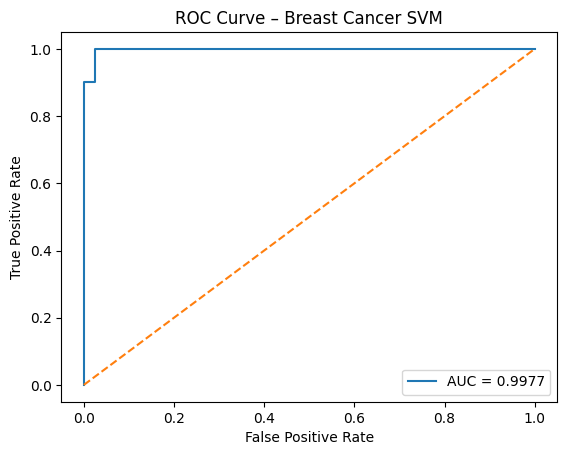

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print("AUC Score:", roc_auc)

with open("outputs/auc_score.txt", "w") as f:
    f.write(f"AUC Score: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Breast Cancer SVM")
plt.legend()
plt.savefig("outputs/roc_curve.png")
plt.show()


In [22]:
joblib.dump(best_model, "model/svm_pipeline.pkl")
print("Model saved successfully.")


Model saved successfully.
